In [1]:
import pandas as pd
import numpy as np

import multidict as multidict

import datetime
from dateutil.relativedelta import relativedelta


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

#from PIL import Image
from wordcloud import WordCloud

import multidict as multidict

import os

import spacy

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # per stampare tutti gli output

2023-01-11 16:30:57.236644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# GOOGLE MAPS SCRAPING

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time 


# APERTURA BROWSER
chromedrive_path = '/Users/Emanuele/Desktop/chromedriver' # use the path to the driver you downloaded from previous steps
driver = webdriver.Chrome(chromedrive_path)

url = "https://www.google.com/search?q=mauto&oq=mauto&aqs=chrome.0.0i271j46i175i199i512j69i59j46i512j0i512j0i10i512j0i512j46i175i199i512j46i512j46i10i175i199i512.1321j1j15&sourceid=chrome&ie=UTF-8#lrd=0x478812ba8eef5987:0xcfc6e9696ae6132,1,,,"
driver.get(url)

wait = WebDriverWait(driver, 2)


# COOKIES
time.sleep(2)
ele = driver.find_element(By.CSS_SELECTOR, ".sy4vM")
driver.execute_script('arguments[0].scrollBy(0, document.body.scrollHeight);', ele)
time.sleep(2)

driver.find_element(By.CSS_SELECTOR, '.sy4vM').click() # click accetta/rifiuta
time.sleep(2)



# ORDINARE RECENSIONI PIU RECENTI
time.sleep(1)
driver.find_element(By.CSS_SELECTOR, '.k1U36b:nth-child(2)').click()
time.sleep(1)



# SCROLLING
SCROLL_PAUSE_TIME = 2 # costante in sec

# scroll
ele = driver.find_element(By.CSS_SELECTOR, ".review-dialog-list")
driver.execute_script('arguments[0].scrollBy(0, document.body.scrollHeight);', ele)

rip = 1
while True:
    # scroll fino al fondo
    ele = driver.find_element(By.CSS_SELECTOR, ".review-dialog-list")
    driver.execute_script('arguments[0].scrollBy(0, document.body.scrollHeight);', ele)

    time.sleep(SCROLL_PAUSE_TIME)
    
    rip = rip + 1

    # condizione di fine loop
    if rip > 6:
        break

item = driver.find_elements(By.CSS_SELECTOR, ".review-dialog-list") # oggetto finestra recensioni che ormai contiene tutte le recensioni aperte e scrollate

# oggetti vuoti x dataframe
name_list = []
stars_list = []
data_list = []
text_list = []


# APRIRE TUTTE LE RECENSIONI COMPLETE
for i in item:
    button = i.find_elements(By.CSS_SELECTOR, ".review-more-link") # risalgo e apro tutta le recensioni cliccando su "altro" 
    time.sleep(SCROLL_PAUSE_TIME)
    for m in button:
        if m.text == "Altro":
            #time.sleep(1)
            m.click()
    #time.sleep(2)

    # ESTRAZIONE INFORMAZIONI
    name = i.find_elements(By.CSS_SELECTOR, ".TSUbDb a") # nome autore
    stars = i.find_elements(By.CSS_SELECTOR, "g-review-stars > span") # valutazione
    data = i.find_elements(By.CSS_SELECTOR, ".dehysf") # data 
    text = i.find_elements(By.CSS_SELECTOR, ".Jtu6Td") # testo


# CREAZIONE DATASET
for j,k,p,l in zip(name, stars, data, text):
    name_list.append(j.text)
    stars_list.append(k.get_attribute("aria-label"))
    data_list.append(p.text)
    text_list.append(l.text)

review = pd.DataFrame({'nome': name_list, 'valutazione': stars_list, 'data': data_list, 'testo': text_list})
#review.to_excel('google_review.xlsx',index=False)

driver.close()

/var/folders/0s/04xm91d10s387g138h0pvdrc0000gn/T/ipykernel_21416/3931074925.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chromedrive_path)


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000101e01f38 chromedriver + 4910904
1   chromedriver                        0x0000000101d81a03 chromedriver + 4385283
2   chromedriver                        0x00000001019c6747 chromedriver + 472903
3   chromedriver                        0x000000010199cff5 chromedriver + 303093
4   chromedriver                        0x0000000101a35b0f chromedriver + 928527
5   chromedriver                        0x0000000101a4b763 chromedriver + 1017699
6   chromedriver                        0x0000000101a30ee3 chromedriver + 909027
7   chromedriver                        0x00000001019fb30c chromedriver + 688908
8   chromedriver                        0x00000001019fc88e chromedriver + 694414
9   chromedriver                        0x0000000101dcf1de chromedriver + 4702686
10  chromedriver                        0x0000000101dd3b19 chromedriver + 4721433
11  chromedriver                        0x0000000101ddb28e chromedriver + 4752014
12  chromedriver                        0x0000000101dd491a chromedriver + 4725018
13  chromedriver                        0x0000000101da8b02 chromedriver + 4545282
14  chromedriver                        0x0000000101df3888 chromedriver + 4851848
15  chromedriver                        0x0000000101df3a05 chromedriver + 4852229
16  chromedriver                        0x0000000101e09e5f chromedriver + 4943455
17  libsystem_pthread.dylib             0x00007ff8055cc4e1 _pthread_start + 125
18  libsystem_pthread.dylib             0x00007ff8055c7f6b thread_start + 15


In [25]:
# Museo Automobile GOOGLE MAPS

GMmauto = pd.read_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/GoogleMapsMauto.xlsx", usecols = ["Data", "Testo", "Valutazione"]) # lettura dataset


# 1 - pulizia <div>
delimiter = "Visitato"

x = GMmauto["Testo"].str.split(delimiter, expand=True)
GMmauto["testo_clean1"] = x[0]

GMmauto = GMmauto.drop("Testo", axis=1)



# 2 - pulizia traduzione "dopo"
delimiter="(Originale)"

x = GMmauto["testo_clean1"].str.split(delimiter, expand=True)
GMmauto["testo_clean2"] = x[0]

GMmauto = GMmauto.drop("testo_clean1", axis=1)



# 3 - pulizia traduzione "prima"
delimiter="(Traduzione di Google)"

GMmauto["testo"] = GMmauto["testo_clean2"].str.split(delimiter).str[-1]

GMmauto = GMmauto.drop("testo_clean2", axis=1)

#mautoGO.to_excel("/Users/Emanuele/Desktop/TesiMaster/Dataset/Mauto/Google/mautoGO_clean.xlsx")

In [26]:
# pulizia DATA GOOGLE MAPS

delimiter = " "

# separazione "3 giorni fa"
GMmauto["dataStr1"] = GMmauto["Data"].str.split(delimiter).str[1]
GMmauto["dataNum"] = GMmauto["Data"].str.split(delimiter).str[0]
GMmauto["dataStr2"] = GMmauto["Data"].str.split(delimiter).str[-1]

# conversione "un" in valore numero
GMmauto.loc[GMmauto['dataNum'] == "un", 'Num'] = "1"
GMmauto.loc[GMmauto['dataNum'] != 'un', 'Num'] = GMmauto['dataNum']


# conversione "una" in valore numero
GMmauto.loc[GMmauto['dataNum'] == "una", 'Num2'] = "1"
GMmauto.loc[GMmauto['dataNum'] != 'una', 'Num2'] = GMmauto['Num']
GMmauto = GMmauto.drop("dataNum", axis=1)

# concatenazione new colonna data + eliminazione altre colonne
GMmauto["data"] = GMmauto["Num2"] + " " + GMmauto["dataStr1"] + " " + GMmauto["dataStr2"]

GMmauto = GMmauto.drop("Data", axis=1)
GMmauto = GMmauto.drop("dataStr1", axis=1)
GMmauto = GMmauto.drop("dataStr2", axis=1)
GMmauto = GMmauto.drop("Num", axis=1)
GMmauto = GMmauto.drop("Num2", axis=1)


GMmauto.head(10)

,Valutazione,testo,data
0,"Valutazione: 4,0 su 5,","Bella esperienza, dalla storia del motore ai g...",58 minuti fa
1,"Valutazione: 5,0 su 5,",Erano anni che non ci tornavo e sono stata pia...,11 ore fa
2,"Valutazione: 5,0 su 5,","Museo unico nel sup genere, moltissime auto di...",15 ore fa
3,"Valutazione: 5,0 su 5,","Splendido, unico in Italia, da andarci apposta...",20 ore fa
4,"Valutazione: 5,0 su 5,",NaN,1 giorno fa
5,"Valutazione: 5,0 su 5,",,1 giorno fa
6,"Valutazione: 5,0 su 5,",,1 giorno fa
7,"Valutazione: 5,0 su 5,",") Super museo le auto, l'atmosfera decorativa,...",1 giorno fa
8,"Valutazione: 5,0 su 5,",NaN,1 giorno fa
9,"Valutazione: 5,0 su 5,",Io non sono un'amante delle automobili eppure ...,1 giorno fa


In [27]:
# conversione DATA GOOGLE MAPS 

def get_past_date(str_days_ago):
    TODAY = datetime.date.today()
    splitted = str_days_ago.split()

    if splitted[1].lower() in ['minuto','minuti']:
        date = datetime.datetime.now() - relativedelta(minutes=int(splitted[0]))
        return str(date.date().isoformat())
    
    elif splitted[1].lower() in ['ora','ore']:
        date = datetime.datetime.now() - relativedelta(hours=int(splitted[0]))
        return str(date.date().isoformat())
    
    elif splitted[1].lower() in ['giorno','giorni']:
        date = TODAY - relativedelta(days=int(splitted[0]))
        return str(date.isoformat())
    
    elif splitted[1].lower() in ['settimana','settimane']:
        date = TODAY - relativedelta(weeks=int(splitted[0]))
        return str(date.isoformat())
   
    elif splitted[1].lower() in ["mese","mesi"]:
        date = TODAY - relativedelta(months=int(splitted[0]))
        return str(date.isoformat())
    
    elif splitted[1].lower() in ['anno','anni']:
        date = TODAY - relativedelta(years=int(splitted[0]))
        return str(date.isoformat())
    
    else:
        return "Errore"



GMmauto["data"] = GMmauto.apply(lambda row: get_past_date(row['data']), axis=1)
GMmauto.head(10)

,Valutazione,testo,data
0,"Valutazione: 4,0 su 5,","Bella esperienza, dalla storia del motore ai g...",2023-01-03
1,"Valutazione: 5,0 su 5,",Erano anni che non ci tornavo e sono stata pia...,2023-01-02
2,"Valutazione: 5,0 su 5,","Museo unico nel sup genere, moltissime auto di...",2023-01-02
3,"Valutazione: 5,0 su 5,","Splendido, unico in Italia, da andarci apposta...",2023-01-02
4,"Valutazione: 5,0 su 5,",NaN,2023-01-02
5,"Valutazione: 5,0 su 5,",,2023-01-02
6,"Valutazione: 5,0 su 5,",,2023-01-02
7,"Valutazione: 5,0 su 5,",") Super museo le auto, l'atmosfera decorativa,...",2023-01-02
8,"Valutazione: 5,0 su 5,",NaN,2023-01-02
9,"Valutazione: 5,0 su 5,",Io non sono un'amante delle automobili eppure ...,2023-01-02


In [28]:
# pulizia PUNTEGGIO RECENSIONI GOOGLE MAPS

def star(row): 
    val = str(row['Valutazione'])
    return val[13]


GMmauto['punteggio'] = GMmauto.apply(star, axis=1)

GMmauto = GMmauto.drop("Valutazione", axis=1)

GMmauto.head(10)

,testo,data,punteggio
0,"Bella esperienza, dalla storia del motore ai g...",2023-01-03,4
1,Erano anni che non ci tornavo e sono stata pia...,2023-01-02,5
2,"Museo unico nel sup genere, moltissime auto di...",2023-01-02,5
3,"Splendido, unico in Italia, da andarci apposta...",2023-01-02,5
4,NaN,2023-01-02,5
5,,2023-01-02,5
6,,2023-01-02,5
7,") Super museo le auto, l'atmosfera decorativa,...",2023-01-02,5
8,NaN,2023-01-02,5
9,Io non sono un'amante delle automobili eppure ...,2023-01-02,5


In [2]:
# TRIPADVISOR SCRAPING
import sys
import csv

# APERTURA BROWSER
chromedrive_path = '/Users/Emanuele/Desktop/chromedriver' # use the path to the driver you downloaded from previous steps
driver = webdriver.Chrome(chromedrive_path)


url = "https://www.tripadvisor.it/Attraction_Review-g187855-d232103-Reviews-Museo_Nazionale_dell_Automobile-Turin_Province_of_Turin_Piedmont.html"
driver.get(url)

wait = WebDriverWait(driver, 2)


# COOKIES
time.sleep(2)
driver.find_element(By.XPATH, '//*[@id="onetrust-accept-btn-handler"]').click() # click accetta
time.sleep(2)


# change the value inside the range to save more or less reviews
num_page = 2 # default number of scraped pages

# oggetti vuoti x dataframe
name_list = []
title_list = []
location_list = []
stars_list = []
data_list = []
text_list = []


# LOOP CAMBIO PAGINA
for rip in range(0, num_page):
    
    # scroll 
    time.sleep(2)
    ele = driver.find_element(By.TAG_NAME, "body")
    driver.execute_script('arguments[0].scrollBy(0, document.body.scrollHeight);', ele)
    
    container = driver.find_elements(By.CSS_SELECTOR, ".LbPSX")

    for rip2 in container:
        
        name = rip2.find_elements(By.CSS_SELECTOR, ".zpDvc .ukgoS")
        title = rip2.find_elements(By.CSS_SELECTOR, ".ukgoS .yCeTE")
        location = rip2.find_elements(By.CSS_SELECTOR, "#tab-data-qa-reviews-0 .osNWb span:nth-child(1)")
        data = rip2.find_elements(By.CSS_SELECTOR, ".TreSq .ncFvv")
        rating = rip2.find_elements(By.CSS_SELECTOR, '#tab-data-qa-reviews-0 .f.k+ div > *')
        review = rip2.find_elements(By.CSS_SELECTOR,".KxBGd .yCeTE")

        # CREAZIONE DATASET
        for n, t, l, s, d, t in zip(name, title, location, rating, data, review):
            name_list.append(n.text)
            title_list.append(t.text)
            location_list.append(l.text)
            stars_list.append(s.get_attribute("aria-label"))
            data_list.append(d.text)
            text_list.append(t.text)
            
            review = pd.DataFrame({'nome': name_list, 'titolo': title_list, 'posizione': location_list, 'valutazione': stars_list, 'data': data_list, 'testo': text_list})
            #review.to_excel('google_review.xlsx',index=False)


    # bottone pagina successiva
    driver.find_element(By.CSS_SELECTOR, '#tab-data-qa-reviews-0 .unMkR').click()

driver.close()

NameError: name 'webdriver' is not defined

In [29]:
# Mauto TRIPADVISOR

TAmauto = pd.read_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/TripAdvisorMauto.xlsx", usecols=["testo", "data", "titolo", "punteggio"]) # lettura dataset

TAmauto.head(10)

,data,titolo,testo,punteggio
0,20 novembre 2022,Visita di lavoro e di svago.,"Tornato al MAuto dopo anni di assenza, sono ri...",5
1,9 novembre 2022,Grande delusione,Francamente deludente! Poche le auto di riliev...,2
2,5 novembre 2022,Eccezionale,Nella zona ospedaliera della città e adiacente...,5
3,1 novembre 2022,Top,"Favoloso, per tutte le età, ottima organizzazi...",5
4,16 ottobre 2022,Museo automobile,Fantastico i miei bimbi si sono divertiti un s...,5
5,3 ottobre 2022,Eccezionale esperienza,Consilio questa visita che per me è stata fant...,5
6,2 ottobre 2022,Auto che passione!,Abbiamo trascorso un piacevole pomeriggio in q...,5
7,18 settembre 2022,Imperdibile,Varietà ricchissima di modelli dalle origini f...,5
8,15 settembre 2022,Da vedere e rivedere,"Una vera meraviglia, vedere da vicino tante au...",5
9,4 settembre 2022,Tappa fissa,"Situato vicino il ""lingotto"" tappa fissa da vi...",4


In [30]:
# conversione DATA TRIPDAVISOR

import locale

locale.setlocale(locale.LC_ALL, 'it_IT')

TAmauto['data'] = pd.to_datetime(TAmauto['data'], format = '%d %B %Y')

TAmauto.head(10)

'it_IT'

,data,titolo,testo,punteggio
0,2022-11-20,Visita di lavoro e di svago.,"Tornato al MAuto dopo anni di assenza, sono ri...",5
1,2022-11-09,Grande delusione,Francamente deludente! Poche le auto di riliev...,2
2,2022-11-05,Eccezionale,Nella zona ospedaliera della città e adiacente...,5
3,2022-11-01,Top,"Favoloso, per tutte le età, ottima organizzazi...",5
4,2022-10-16,Museo automobile,Fantastico i miei bimbi si sono divertiti un s...,5
5,2022-10-03,Eccezionale esperienza,Consilio questa visita che per me è stata fant...,5
6,2022-10-02,Auto che passione!,Abbiamo trascorso un piacevole pomeriggio in q...,5
7,2022-09-18,Imperdibile,Varietà ricchissima di modelli dalle origini f...,5
8,2022-09-15,Da vedere e rivedere,"Una vera meraviglia, vedere da vicino tante au...",5
9,2022-09-04,Tappa fissa,"Situato vicino il ""lingotto"" tappa fissa da vi...",4


In [31]:
# unione colonna "titolo" e "testo" TRIPADVISOR

TAmauto['testo'] = TAmauto[["titolo", "testo"]].apply(". ".join, axis=1)

TAmauto = TAmauto.drop("titolo", axis=1)


TAmauto.head(10)

,data,testo,punteggio
0,2022-11-20,Visita di lavoro e di svago.. Tornato al MAuto...,5
1,2022-11-09,Grande delusione. Francamente deludente! Poche...,2
2,2022-11-05,Eccezionale . Nella zona ospedaliera della cit...,5
3,2022-11-01,"Top. Favoloso, per tutte le età, ottima organi...",5
4,2022-10-16,Museo automobile. Fantastico i miei bimbi si s...,5
5,2022-10-03,Eccezionale esperienza. Consilio questa visita...,5
6,2022-10-02,Auto che passione!. Abbiamo trascorso un piace...,5
7,2022-09-18,Imperdibile. Varietà ricchissima di modelli da...,5
8,2022-09-15,"Da vedere e rivedere. Una vera meraviglia, ved...",5
9,2022-09-04,"Tappa fissa. Situato vicino il ""lingotto"" tapp...",4


In [32]:
# UNIONE 2 DATASET GOOGLE MAPS + TRIPADVISOR

Auto = pd.concat([TAmauto, GMmauto], axis=0)


Auto["testo"] = Auto["testo"].str.strip() # rimozione spazi prima e dopo
Auto["testo"] = Auto["testo"].str.replace(r'[^A-Za-z0-9àèéòìù,.!?;]+\s?', ' ', regex=True) # rimozione menzioni
Auto["testo"] = Auto["testo"].str.replace(r'@[A-Za-z0-9]+\s?', ' ', regex=True) # rimozione menzioni
Auto["testo"] = Auto["testo"].str.replace(r'#[A-Za-z0-9]+\s?', ' ', regex=True) # rimozione hashtag
Auto["testo"] = Auto["testo"].str.replace(r'https*\S+', ' ', regex=True) # rimozione URL
Auto["testo"] = Auto["testo"].str.replace(r'(', ' ', regex=True) # rimozione parentesi
Auto["testo"] = Auto["testo"].str.replace(r')', ' ', regex=True) # rimozione parentesi
Auto["testo"] = Auto["testo"].str.replace(r'...Altro', '', regex=True) # rimozione parentesi
Auto = Auto.dropna() # rimozione righe NaN

# rimozione righe blank
Auto['testo'].replace("", np.nan, inplace = True)
Auto.dropna(subset=['testo'], inplace = True)


Auto.head(10)

Auto.to_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/Auto.xlsx")

,data,testo,punteggio
0,2022-11-20 00:00:00,Visita di lavoro e di svago.. Tornato al MAuto...,5
1,2022-11-09 00:00:00,Grande delusione. Francamente deludente! Poche...,2
2,2022-11-05 00:00:00,Eccezionale . Nella zona ospedaliera della cit...,5
3,2022-11-01 00:00:00,"Top. Favoloso, per tutte le età, ottima organi...",5
4,2022-10-16 00:00:00,Museo automobile. Fantastico i miei bimbi si s...,5
5,2022-10-03 00:00:00,Eccezionale esperienza. Consilio questa visita...,5
6,2022-10-02 00:00:00,Auto che passione!. Abbiamo trascorso un piace...,5
7,2022-09-18 00:00:00,Imperdibile. Varietà ricchissima di modelli da...,5
8,2022-09-15 00:00:00,"Da vedere e rivedere. Una vera meraviglia, ved...",5
9,2022-09-04 00:00:00,Tappa fissa. Situato vicino il lingotto tappa ...,4


In [10]:
Mauto = Auto # copia per poterli confrontare senza dover rilanciare tutto 


# DATA CLEANING

# Mauto_clean.drop_duplicates(inplace = True) # rimozione righe duplicate
Mauto["testo"] = Mauto["testo"].str.lower() # testo in minuscolo
Mauto["testo"] = Mauto["testo"].str.replace('\w*\d+\w*', ' ', regex=True) # rimozione numeri
Mauto["testo"] = Mauto["testo"].str.replace('[^\w\s]', ' ', regex=True) # rimozione punteggiatura
Mauto["testo"] = Mauto["testo"].str.replace('\n', ' ', regex=True) # rimozione \n
Mauto['testo'] = Mauto['testo'].fillna("") # sostituzione NaN con cella vuota

Mauto.head(10)

Mauto.to_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/Mauto_clean.xlsx")

,data,testo,punteggio
0,2022-11-20 00:00:00,visita di lavoro e di svago tornato al mauto...,5
1,2022-11-09 00:00:00,grande delusione francamente deludente poche...,2
2,2022-11-05 00:00:00,eccezionale nella zona ospedaliera della cit...,5
3,2022-11-01 00:00:00,top favoloso per tutte le età ottima organi...,5
4,2022-10-16 00:00:00,museo automobile fantastico i miei bimbi si s...,5
5,2022-10-03 00:00:00,eccezionale esperienza consilio questa visita...,5
6,2022-10-02 00:00:00,auto che passione abbiamo trascorso un piace...,5
7,2022-09-18 00:00:00,imperdibile varietà ricchissima di modelli da...,5
8,2022-09-15 00:00:00,da vedere e rivedere una vera meraviglia ved...,5
9,2022-09-04 00:00:00,tappa fissa situato vicino il lingotto tappa ...,4


In [11]:
Mauto_clean = Mauto # copia per poterli confrontare senza dover rilanciare tutto 


# STOPWORDS

stop_words_ita = stopwords.words('italian')
stop_words_eng = stopwords.words('english')

# import file excel con stopwords
sw_excel = pd.read_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/stopwords.xlsx", usecols = ['word'])
sw_excel = [word.strip() for word in sw_excel.word] # rimozione eventuali spazi prima e dopo la stopword 

# applicazione stopword alla colonna testo
Mauto_clean["testo"] = Mauto_clean["testo"].apply(lambda x: ' '.join([word for word in x.split() if word not in sw_excel and word not in stop_words_ita and word not in stop_words_eng]))


Mauto_clean.head(10)

/Users/Emanuele/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,data,testo,punteggio
0,2022-11-20 00:00:00,visita lavoro svago tornato mauto assenza rima...,5
1,2022-11-09 00:00:00,delusione francamente deludente poche auto ril...,2
2,2022-11-05 00:00:00,eccezionale zona ospedaliera adiacente lingott...,5
3,2022-11-01 00:00:00,top favoloso età ottima organizzazione esperie...,5
4,2022-10-16 00:00:00,museo automobile fantastico bimbi divertiti sa...,5
5,2022-10-03 00:00:00,eccezionale esperienza consilio visita fantast...,5
6,2022-10-02 00:00:00,auto passione trascorso piacevole pomeriggio m...,5
7,2022-09-18 00:00:00,imperdibile varietà ricchissima modelli origin...,5
8,2022-09-15 00:00:00,vedere rivedere vera meraviglia vedere tante a...,5
9,2022-09-04 00:00:00,tappa fissa situato lingotto tappa fissa visit...,4


In [12]:
# LEMMATIZZAZIONE

nlpIT = spacy.load('it_core_news_lg')

# funzione per lemmatizzare
def lemming_word(text):
    lemma_clean = [] 
    doc = nlpIT(text.lower()) #trasforma tutte le parole in maiuscolo in minuscolo
    
    for token in doc:
        #if token.pos_ in ['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV']: # se la parola non è un URL e non è nella lista stop word, allora mette il lemma nel vettore "tokens"
        lemma_clean.append(token.lemma_)
    lemma_clean = " ".join(set(lemma_clean)) # trasforma vettore tokens in una stringa
    return lemma_clean


corpus = [] # corpus è un vettore di stringhe "pulite"
for i in Mauto_clean["testo"]:
    vett = lemming_word(str(i))
    #if vett != "":
    corpus.append(vett)


# coversione da lista in dF
Mauto_clean = pd.DataFrame(corpus, columns = ["testo"])

Mauto_clean.head(10)

,testo
0,tornare maere visita sbalordire imparare riman...
1,guida visita conseguire rilievo pena molto hp ...
2,adiacente visita esporre straordinario eccezio...
3,torino top abbonamento favoloso museo ottimo b...
4,fantastico automobile vedere pena bimbo museo ...
5,meravigliare si visita eccezionale esperienza ...
6,passione vedere pomeriggio piacevole esperienz...
7,origine struttura imperdibile impeccabile tene...
8,antico meraviglia vero automobile vedere tanto...
9,tappa ripercorrere situare pecca potere Lingot...


In [13]:
# STOPWORDS CLEANING 2

# ri-applicazione stopword alla colonna testo
Mauto_clean["testo"] = Mauto_clean["testo"].apply(lambda x: ' '.join([word for word in x.split() if word not in sw_excel and word not in stop_words_ita]))
Mauto_clean["testo"] = Mauto_clean["testo"].str.lower() # testo in minuscolo


Mauto_clean.head(10)

Mauto_clean.to_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/Mauto_lemm.xlsx")

,testo
0,tornare maere visita sbalordire imparare riman...
1,guida visita conseguire rilievo pena hp delude...
2,adiacente visita esporre straordinario eccezio...
3,torino top abbonamento favoloso museo ottimo b...
4,fantastico automobile vedere pena bimbo museo ...
5,meravigliare visita eccezionale esperienza pro...
6,passione vedere pomeriggio piacevole esperienz...
7,origine struttura imperdibile impeccabile tene...
8,antico meraviglia vero automobile vedere stori...
9,tappa ripercorrere situare pecca potere lingot...


In [15]:
# RIMOZIONE PAROLE IN INGLESE
'''

import nltk
words = set(nltk.corpus.words.words())


textRemoveEngl = " ".join(str(i) for i in GMmauto_clean["testo"]) # trasformazione in stringa


textRemoveEngl = " ".join(w for w in nltk.wordpunct_tokenize(textRemoveEngl) \
         if w.lower() not in words or not w.isalpha())

textRemoveEngl = textRemoveEngl.split()
GMmauto_clean2 = pd.DataFrame (textRemoveEngl, columns = ['testo'])
GMmauto_clean2.head(10)

'''

'\n\nimport nltk\nwords = set(nltk.corpus.words.words())\n\n\ntextRemoveEngl = " ".join(str(i) for i in GMmauto_clean["testo"]) # trasformazione in stringa\n\n\ntextRemoveEngl = " ".join(w for w in nltk.wordpunct_tokenize(textRemoveEngl)          if w.lower() not in words or not w.isalpha())\n\ntextRemoveEngl = textRemoveEngl.split()\nGMmauto_clean2 = pd.DataFrame (textRemoveEngl, columns = [\'testo\'])\nGMmauto_clean2.head(10)\n\n'

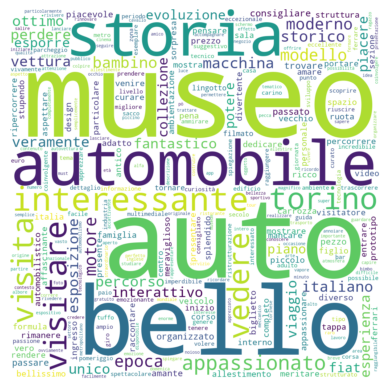

In [16]:
# WORDCLOUD

# funzione per dimensione parole in base alla frequenza
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def makeImage(text):
    wc = WordCloud(background_color="white", max_words=300, width=1200, height=1200)
    # generate word cloud
    wc.generate_from_frequencies(text)
    wc.to_file("./Export/wordcloudMauto.png")


    # show
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.show()
    #plt.savefig("./Export/wordcloudMauto.png", format = "png")

textWC = " ".join(str(i) for i in Mauto_clean["testo"]) # trasformazione in stringa
makeImage(getFrequencyDictForText(textWC))

[Text(0, 0, 'museo'),
 Text(1, 0, 'auto'),
 Text(2, 0, 'bello'),
 Text(3, 0, 'automobile'),
 Text(4, 0, 'storia'),
 Text(5, 0, 'interessante'),
 Text(6, 0, 'visitare'),
 Text(7, 0, 'torino'),
 Text(8, 0, 'visita'),
 Text(9, 0, 'vedere'),
 Text(10, 0, 'appassionato'),
 Text(11, 0, 'motore'),
 Text(12, 0, 'epoca'),
 Text(13, 0, 'modello'),
 Text(14, 0, 'moderno'),
 Text(15, 0, 'bambino'),
 Text(16, 0, 'storico'),
 Text(17, 0, 'macchina'),
 Text(18, 0, 'italiano'),
 Text(19, 0, 'percorso'),
 Text(20, 0, 'ottimo'),
 Text(21, 0, 'esposizione'),
 Text(22, 0, 'perdere'),
 Text(23, 0, 'vettura'),
 Text(24, 0, 'veramente'),
 Text(25, 0, 'interattivo'),
 Text(26, 0, 'viaggio'),
 Text(27, 0, 'esperienza'),
 Text(28, 0, 'unico'),
 Text(29, 0, 'fantastico')]

[Text(0, 0, '3919'),
 Text(0, 0, '3379'),
 Text(0, 0, '2444'),
 Text(0, 0, '2208'),
 Text(0, 0, '2183'),
 Text(0, 0, '1558'),
 Text(0, 0, '1383'),
 Text(0, 0, '1305'),
 Text(0, 0, '1284'),
 Text(0, 0, '1261'),
 Text(0, 0, '1080'),
 Text(0, 0, '709'),
 Text(0, 0, '692'),
 Text(0, 0, '663'),
 Text(0, 0, '634'),
 Text(0, 0, '606'),
 Text(0, 0, '598'),
 Text(0, 0, '580'),
 Text(0, 0, '553'),
 Text(0, 0, '533'),
 Text(0, 0, '522'),
 Text(0, 0, '514'),
 Text(0, 0, '510'),
 Text(0, 0, '503'),
 Text(0, 0, '498'),
 Text(0, 0, '460'),
 Text(0, 0, '453'),
 Text(0, 0, '451'),
 Text(0, 0, '450'),
 Text(0, 0, '446')]

Text(0.5, 1.07, "Parole più frequenti del Museo dell'Automobile su Google Maps e TripAdvisor")

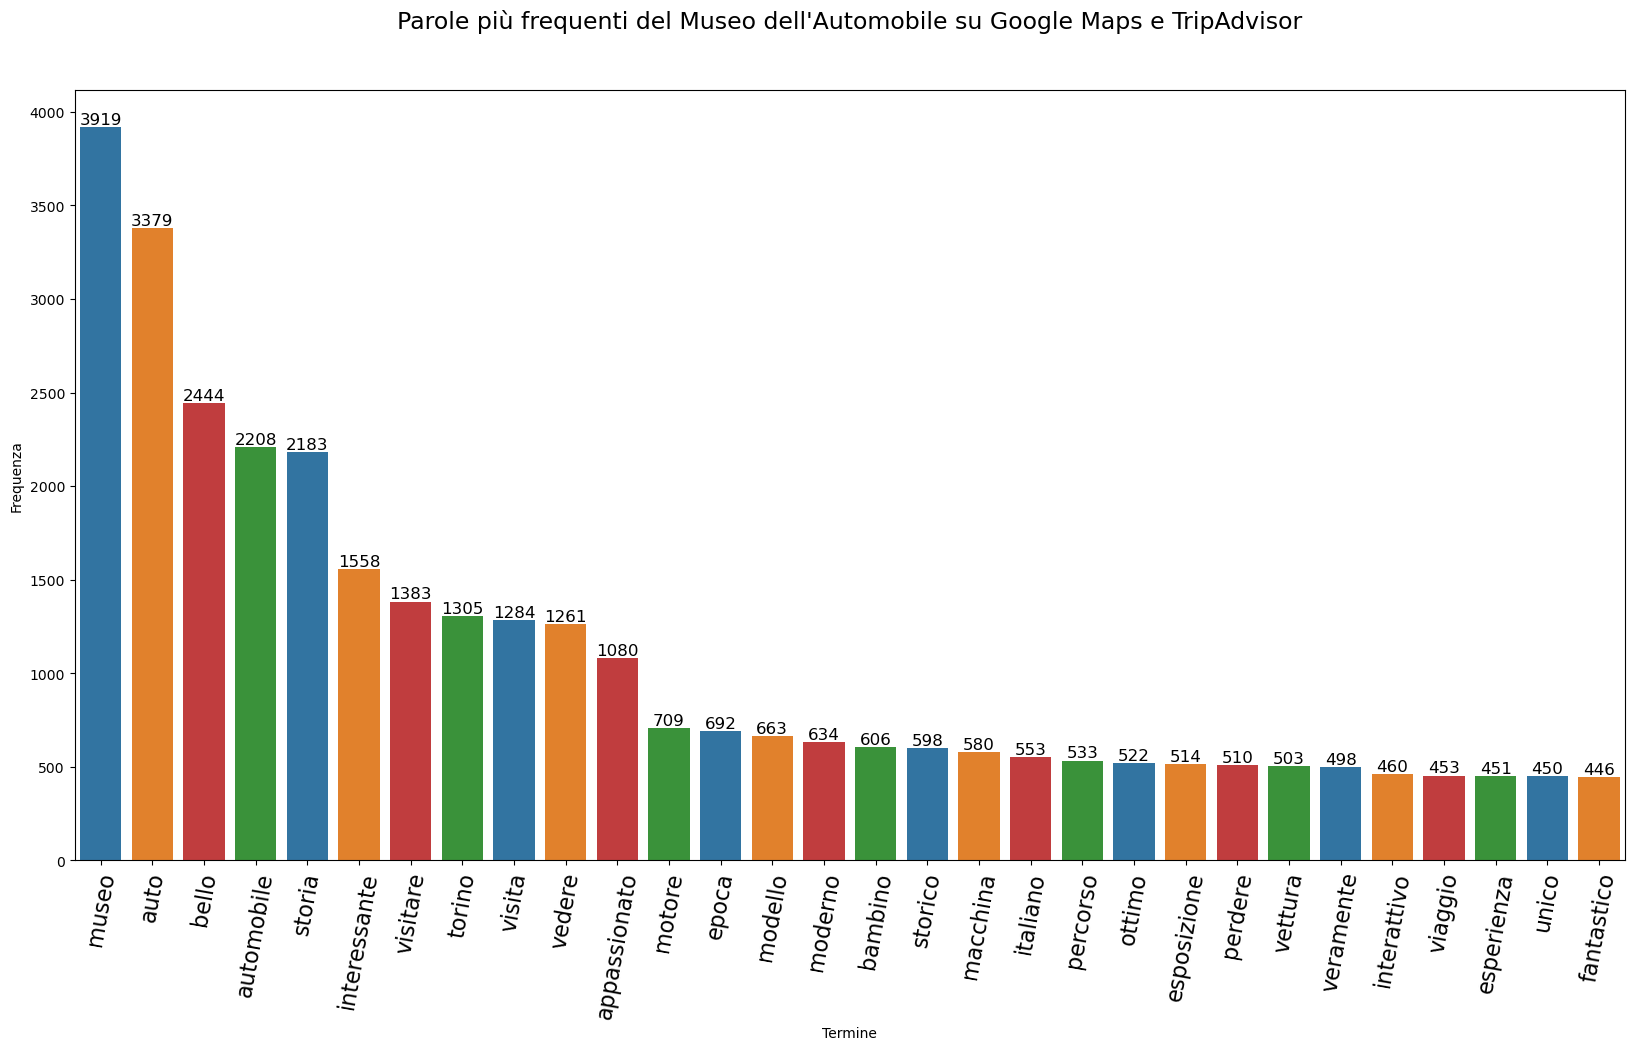

In [17]:
# FREQUENZA PAROLE

freq_mauto = Mauto_clean.testo.str.split(expand=True).stack().value_counts().reset_index() 
freq_mauto.columns = ['Termine', 'Frequenza'] 


# SUBSET 30 parole più frequenti 
freq_mauto_subset = freq_mauto.sort_values('Frequenza', ascending = False).iloc[:30]


# grafico
import seaborn as sns

fig = plt.figure(figsize = (20, 10))
plot = sns.barplot(x = "Termine", y = "Frequenza", data = freq_mauto_subset.sort_values('Frequenza', ascending = False), palette = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green'])    
plot.set_xticklabels(rotation = 80, fontsize = 16, labels = freq_mauto_subset.sort_values('Frequenza', ascending = False).Termine) # etichette parole

plt.bar_label(plot.containers[0], fontsize = 12) # label sopra gli assi

plt.title("Parole più frequenti del Museo dell'Automobile su Google Maps e TripAdvisor", y = 1.07, fontsize = 17)

plt.savefig("./Export/FreqWordMauto.png", format = "png")


freq_mauto.to_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/FreqParole_Mauto.xlsx")

In [14]:
# lista di parole da eliminare da LDA perchè poco caratteristiche

no_tipical_word = [
    "museo", "auto", "automobile", "macchina", "motore", 
    "visitare", "vedere", "vista", "esposizione", "mostra",
    "torino", "automobilistico", "italiano", "visita", "car",
    "cars", "vettura"
    ]
remove = r'\b(?:{})\b'.format('|'.join(no_tipical_word))

Mauto_cleanLDA = Mauto_clean["testo"].str.replace(remove, '')


/var/folders/0s/04xm91d10s387g138h0pvdrc0000gn/T/ipykernel_1781/3223458819.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  Mauto_cleanLDA = Mauto_clean["testo"].str.replace(remove, '')


In [15]:
# LDA

cv = CountVectorizer()
dtm = cv.fit_transform(Mauto_cleanLDA) 

# creazione di un modello impostando di default i parametri che vogliamo
LDA = LatentDirichletAllocation(n_components = 5, n_jobs = -1) # funzione per specificare il numero di cluster
LDA.fit(dtm)


for index, topic in enumerate(LDA.components_):
    print(f"TOPIC %d - TOP 30 PAROLE DEL CLUSTER" % (index+1))
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    print('\n')

LatentDirichletAllocation(n_components=5, n_jobs=-1)

TOPIC 1 - TOP 30 PAROLE DEL CLUSTER
['vecchio', 'qualità', 'design', 'potere', 'interessante', 'viaggio', 'prezzo', 'italia', 'percorso', 'veicolo', 'pensare', 'unico', 'personale', 'piano', 'aspettare', 'rendere', 'moderno', 'epoca', 'perdere', 'biglietto', 'incredibile', 'esporre', 'trovare', 'mostrare', 'ottimo', 'fiat', 'collezione', 'modello', 'bello', 'storia']


TOPIC 2 - TOP 30 PAROLE DEL CLUSTER
['fantastico', 'bambino', 'struttura', 'metro', 'modello', 'prototipo', 'pezzo', 'interattivo', 'mancare', 'lingotto', 'passare', 'unico', 'dedicare', 'piano', 'rimanere', 'ferrari', 'storico', 'perdere', 'meritare', 'veramente', 'collezione', 'amante', 'ottimo', 'appassionato', 'fiat', 'epoca', 'interessante', 'moderno', 'storia', 'bello']


TOPIC 3 - TOP 30 PAROLE DEL CLUSTER
['divertente', 'diverso', 'potere', 'allestimento', 'veramente', 'italia', 'pezzo', 'consigliare', 'meraviglioso', 'affascinante', 'vero', 'collezione', 'ottimo', 'trovare', 'ripercorrere', 'interattivo', 'fanta

In [16]:
# creazione e addestramento 2° modello LDA con parametri diversi

LDA2 = LatentDirichletAllocation(learning_decay = 0.9, n_components = 3)

LDA2.fit(dtm)


for index, topic in enumerate(LDA2.components_):
    print(f"TOPIC %d - TOP 30 PAROLE DEL CLUSTER" % (index+1))
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    print('\n')


# VALUTAZIONE MODELLO LDA

# Log Likelyhood: Higher the better
#print("Log Likelihood: ", LDA.score(dtm))

# Perplexity: Lower the better
#print("Perplexity: ", LDA.perplexity(dtm))
#print("\n")

# See model parameters
# print(LDA.get_params())


# perplexity might not be the best measure to evaluate topic models 
# because it doesn’t consider the context and semantic associations between words.

LatentDirichletAllocation(learning_decay=0.9, n_components=3)

TOPIC 1 - TOP 30 PAROLE DEL CLUSTER
['esperienza', 'veramente', 'fantastico', 'sala', 'ottimo', 'dedicare', 'ruota', 'pezzo', 'potere', 'piano', 'allestimento', 'viaggio', 'percorrere', 'fiat', 'unico', 'passare', 'prototipo', 'carrozza', 'esporre', 'perdere', 'moderno', 'percorso', 'appassionato', 'evoluzione', 'epoca', 'storico', 'interessante', 'modello', 'bello', 'storia']


TOPIC 2 - TOP 30 PAROLE DEL CLUSTER
['dedicare', 'fantastico', 'giro', 'carino', 'mostrare', 'modello', 'interattivo', 'perdere', 'piano', 'aspettare', 'consigliare', 'vecchio', 'mancare', 'moderno', 'bellissimo', 'meritare', 'rimanere', 'figlio', 'potere', 'fiat', 'trovare', 'esperienza', 'appassionato', 'collezione', 'bambino', 'interessante', 'epoca', 'veramente', 'storia', 'bello']


TOPIC 3 - TOP 30 PAROLE DEL CLUSTER
['amante', 'biglietto', 'epoca', 'perdere', 'adatto', 'pena', 'famiglia', 'consigliare', 'unico', 'esperienza', 'piacevole', 'divertente', 'passato', 'ricco', 'storico', 'prezzo', 'fantastico

In [21]:
'''''

# OTTIMIZZAZIONE BEST PARAMETRI PER MODELLO LDA


# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20], 'learning_decay': [0.1, 0.3, 0.5, 0.7, 0.9]}

# creazione modello LDA ottimizzato per applicarci la ricerca dei best parametri
LDA_definitivo = LatentDirichletAllocation(max_iter = 5, learning_method = 'online', learning_offset = 50.,random_state = 0)

# creazione modello GridSearchCV per trovare best parametri dandogli un set di parametri tra cui scegliere
model = GridSearchCV(LDA_definitivo, param_grid = search_params)

# addestramento modello
model.fit(dtm)

# output best parametri del modello 
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dtm))

'''''

'\'\'\n\n# OTTIMIZZAZIONE BEST PARAMETRI PER MODELLO LDA\n\n\n# Define Search Param\nsearch_params = {\'n_components\': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20], \'learning_decay\': [0.1, 0.3, 0.5, 0.7, 0.9]}\n\n# creazione modello LDA ottimizzato per applicarci la ricerca dei best parametri\nLDA_definitivo = LatentDirichletAllocation(max_iter = 5, learning_method = \'online\', learning_offset = 50.,random_state = 0)\n\n# creazione modello GridSearchCV per trovare best parametri dandogli un set di parametri tra cui scegliere\nmodel = GridSearchCV(LDA_definitivo, param_grid = search_params)\n\n# addestramento modello\nmodel.fit(dtm)\n\n# output best parametri del modello \nbest_lda_model = model.best_estimator_\n\n# Model Parameters\nprint("Best Model\'s Params: ", model.best_params_)\n\n# Log Likelihood Score\nprint("Best Log Likelihood Score: ", model.best_score_)\n\n# Perplexity\nprint("Model Perplexity: ", best_lda_model.perplexity(dtm))\n\n'

In [34]:
# Document — Cluster Matrix
DocClusterMatrix = LDA2.transform(dtm) # ---- CAMBIARE QUI "LDA" con "best_lda_model" se si vuole usare modello con parametri ottimizzati ----

# colonna cluster
topicnames = ["Coeff Cluster " + str(i+1) for i in range(LDA2.n_components)] # ---- CAMBIARE QUI "LDA" con "best_lda_model" se si vuole usare modello con parametri ottimizzati ----

# colonna recensioni
#docnames = ["Recensione " + str(i) for i in range(len(GMmauto_clean))]
docnames = Auto["testo"] # dataset con recensioni "leggibili"


# Make the pandas dataframe
Mauto_document_topic = pd.DataFrame(np.round(DocClusterMatrix, 2), columns = topicnames, index = docnames)

# colonna migliore cluster della recensione
dominant_topic = np.argmax(Mauto_document_topic.values, axis = 1)+1
Mauto_document_topic["Cluster"] = dominant_topic


# Styling
def color(val):
 color = "white" if val > 0.0001 and val < 1 else "red"
 return "color: {col}".format(col = color)



# Apply Style
Mauto_document_topic.head(20).style.applymap(color)



# export cluster e recensioni di appartenenza
Mauto_document_topic.to_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/MautoOccorrenzeTopic.xlsx", columns = ["Cluster"])

LatentDirichletAllocation(learning_decay=0.9, n_components=3)

,Coeff Cluster 1,Coeff Cluster 2,Coeff Cluster 3,Cluster
testo,,,,
"Visita di lavoro e di svago.. Tornato al MAuto dopo anni di assenza, sono rimasto sbalordito dalla cura e dall attenzione ai dettagli. Percorso per imparare e sognare! Tutto perfetto!",0.750000,0.240000,0.020000,1
"Grande delusione. Francamente deludente! Poche le auto di rilievo storico in mostra. Un esempio la Isotta Fraschini AN 20 30 HP appartenuta alla Sig.ra Francesca Mirabile Mancuso di Caronia Me , prima donna in Italia a conseguire la patente di guida, non è visionabili in quanto tenta nel garage del museo con molte altre vetture, nonostante lo spazio espositivo disponibile.Non vale la pena la visita!",0.130000,0.860000,0.010000,2
"Eccezionale . Nella zona ospedaliera della città e adiacente al lingotto, è un museo straordinario non solo per le auto esposte, tra cui ci sono anche una Trabant, una Pobeda e due prototipi elettrici della Fiat anni 90 , ma anche per l apparato didascalico, disponibile anche tramite app sul telefonino. Ottima e abbondante la sezione dedicata alla pubblicità dell auto, ricchissima di filmati e che da sola vale la visita.",0.010000,0.990000,0.010000,2
"Top. Favoloso, per tutte le età, ottima organizzazione, un esperienza da fare, per il biglietto consiglio la Torino card per abbonamento a più musei...",0.130000,0.020000,0.850000,3
"Museo automobile. Fantastico i miei bimbi si sono divertiti un sacco fra auto splendide, ambientazioni e auto storiche. Vale la pena almeno una volta ogni tanto vedere le novità",0.730000,0.020000,0.260000,1
Eccezionale esperienza. Consilio questa visita che per me è stata fantastica con ricordi del passato da me vissuto con alcune macchine in esposizione un viaggio nel tempo e meravigliarsi ad ogni padiglione . Da guardare con ammirazione il progresso dell uomo nel costruire e progettare queste autovetture che rimangono nel tempo.,0.170000,0.820000,0.010000,2
Auto che passione!. Abbiamo trascorso un piacevole pomeriggio in questo museo nel quartiere di Lingotto. Esperienza unica anche per i non appassionati di auto e le famiglie. interessante come viene rappresentata la storia dell automobile dai primi passi mossi dagli scienziati fino ai nostri giorni. Sono molti i modelli di auto da vedere e le prove interattive. 5 stelle super meritate!,0.010000,0.920000,0.070000,2
Imperdibile. Varietà ricchissima di modelli dalle origini fino si nostri giorni. Organizzazione impeccabile e struttura ben tenuta,0.020000,0.950000,0.030000,2
"Da vedere e rivedere. Una vera meraviglia, vedere da vicino tante automobili che hanno fatto la nostra storia. Dalle più antiche fino a pochi anni fa, comprese auto di formula uno.",0.010000,0.750000,0.230000,2


In [23]:
# Topic-Keyword Matrix
Mauto_topic_keywords = pd.DataFrame(LDA2.components_) # ---- CAMBIARE QUI "LDA" con "best_lda_model" se si vuole ottimizzare i parametri ----

# Assign Column and Index
Mauto_topic_keywords.columns = cv.get_feature_names_out()
Mauto_topic_keywords.index = topicnames

Mauto_topic_keywords.head()

,aappassionare,abambini,abarth,abbagliare,abbandonare,abbandonato,abbandono,abbassare,abbassato,abbellire,...,zonare,zonda,zono,zonzo,zu,zucco,àndare,èfruibile,èè,élites
Coeff Cluster 1,0.333556,0.333837,0.333520,1.313177,3.334093,0.582195,1.336530,0.333568,0.333398,0.333647,...,1.338160,0.334031,0.333741,1.301155,0.333391,0.361983,0.334664,0.333488,0.334197,0.333369
Coeff Cluster 2,1.332893,1.324010,3.758675,0.353394,0.333556,0.369466,0.333971,1.332942,0.333387,0.333623,...,0.334043,0.334079,0.390550,0.365475,1.333245,5.105608,0.334258,1.333048,1.319319,1.333274
Coeff Cluster 3,0.333550,0.342154,0.907805,0.333428,1.332351,2.048339,1.329499,0.333490,1.333215,1.332731,...,1.327796,1.331890,1.275709,0.333370,0.333363,3.532409,1.331078,0.333464,0.346485,0.333357


In [7]:
# Creazione grafico

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

number_topics = 3
count_data = dtm


A = len(cv.get_feature_names_out())

LDAvis_data_filepath = os.path.join('./Export/Mauto' + str(number_topics))

# this is a bit time consuming - make the if statement True
# if you want to execute visualization prep yourself

if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(LDA2, dtm, cv, mds = 'mmds')
    #print (LDAvis_prepared)
with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared,f,0)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './Export/Mauto'+ str(number_topics) +'.html')

count_data = cv.fit_transform(Mauto_clean["testo"])
#print(count_data)

NameError: name 'dtm' is not defined

In [25]:
MautoNetwork = [word.lower().split() for word in Mauto_clean["testo"]]

MautoNetwork = [[w for w in word if not w in no_tipical_word]
                 for word in MautoNetwork]

In [26]:
from nltk import bigrams

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(word)) for word in MautoNetwork]

# View bigrams for the first tweet
terms_bigram[0]

[('lavoro', 'imparare'),
 ('imparare', 'svago'),
 ('svago', 'sognare'),
 ('sognare', 'assenza'),
 ('assenza', 'cura'),
 ('cura', 'attenzione'),
 ('attenzione', 'maere'),
 ('maere', 'perfetto'),
 ('perfetto', 'sbalordire'),
 ('sbalordire', 'tornare'),
 ('tornare', 'dettaglio'),
 ('dettaglio', 'rimanere'),
 ('rimanere', 'percorrere')]

In [27]:
import itertools
import collections

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(50), columns = ['word', 'count'])

bigram_df.to_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/Bigram_Mauto.xlsx")

bigram_df.head(10)

,word,count
0,"(storia, interessante)",294
1,"(appassionato, storia)",88
2,"(bello, dedicare)",82
3,"(fiat, bello)",82
4,"(storia, esporre)",78
5,"(interessante, moderno)",68
6,"(storia, moderno)",64
7,"(esperienza, bello)",64
8,"(moderno, interattivo)",60
9,"(storia, prezzo)",55


In [28]:
'''''
# NETWORK ANALYSIS 2

import networkx as nx
from pyvis.network import Network

FromToNetworkAnalysis = pd.read_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/FromToNetworkAnalysis.xlsx", usecols = ["from", "to", "count"]) # lettura dataset


G = nx.from_pandas_edgelist(FromToNetworkAnalysis, source = "from", target = "to", edge_attr = "count")


print("No of unique characters:", len(G.nodes))
print("No of connections:", len(G.edges))

# create vis network
net = Network(notebook = True, height="750px", width="100%")
net.toggle_hide_edges_on_drag(True)
net.from_nx(G)
net.show_buttons(filter_= True)
net.toggle_physics(True)



net.show("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/Network2.html")
'''''

'\'\'\n#\xa0NETWORK ANALYSIS 2\n\nimport networkx as nx\nfrom pyvis.network import Network\n\nFromToNetworkAnalysis = pd.read_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/FromToNetworkAnalysis.xlsx", usecols = ["from", "to", "count"]) # lettura dataset\n\n\nG = nx.from_pandas_edgelist(FromToNetworkAnalysis, source = "from", target = "to", edge_attr = "count")\n\n\nprint("No of unique characters:", len(G.nodes))\nprint("No of connections:", len(G.edges))\n\n# create vis network\nnet = Network(notebook = True, height="750px", width="100%")\nnet.toggle_hide_edges_on_drag(True)\nnet.from_nx(G)\nnet.show_buttons(filter_= True)\nnet.toggle_physics(True)\n\n\n\nnet.show("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/Network2.html")\n'

In [29]:
# NETWORK ANALYSIS 2 NIGHT

from pyvis.network import Network

import matplotlib.pyplot as plt


# set the physics layout of the network
got_data = pd.read_excel("/Users/Emanuele/Desktop/TesiMaster/Dati/Museo Automobile/Export/FromToNetworkAnalysis.xlsx")


net = Network(height="1500px", width="100%", bgcolor='#222222', font_color="#ffffff")


net.toggle_hide_edges_on_drag(True)
net.show_buttons(filter_= True)
net.toggle_physics(True)

sources = got_data['from']
targets = got_data['to']
weights = got_data['count']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    net.add_node(src, src, title = src, color = '#87cce5')
    net.add_node(dst, dst, title = dst, color = '#6ca3b7')
    net.add_edge(src, dst, value = w, color = "#dbf0f7")

print("No of unique characters:", len(net.nodes))
print("No of connections:", len(net.edges))

neighbor_map = net.get_adj_list() # restituisce una lista di nodi adiacenti

# label del nodo
for node in net.nodes:
    node['title'] = node['title'] + ' --> ' + ' - '.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])

net.show("./Export/prova.html")


No of unique characters: 47
No of connections: 50


In [30]:
'''''

# NETWORK ANALYSIS 1

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


# Create dictionary of bigrams and their counts
d = bigram_df.set_index('word').T.to_dict('records')


# Create network plot 
G = nx.Graph()


# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight = (v * 10))


fig, ax = plt.subplots(figsize = (16, 12))

pos = nx.spring_layout(G, k = 2)


node_sizes = [3 + 10 * i for i in range(len(G))]

M = G.number_of_edges()

edge_colors = range(2, M + 2)

edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

# Plot networks
nodes = nx.draw_networkx_nodes(G, pos, node_size = node_sizes, node_color = "#A0CBE2")
edges = nx.draw_networkx_edges(G, pos, node_size = node_sizes, edge_color = edge_colors, edge_cmap = cmap, width = 2, alpha = 0.6)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.0135, value[1]+.045
    ax.text(x, y,
            s = key,
            bbox = dict(facecolor = 'white', alpha = 0.15),
            horizontalalignment = 'center', fontsize = 10)


# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Network Analysis Museo dell'Automobile", font)

# colorbar
plt.axis("off")
colors=range(20)
vmin = min(colors)
vmax = max(colors)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)


plt.show()

'''''

'\'\'\n\n#\xa0NETWORK ANALYSIS 1\n\nimport matplotlib as mpl\nimport matplotlib.pyplot as plt\nimport networkx as nx\n\n\n# Create dictionary of bigrams and their counts\nd = bigram_df.set_index(\'word\').T.to_dict(\'records\')\n\n\n# Create network plot \nG = nx.Graph()\n\n\n# Create connections between nodes\nfor k, v in d[0].items():\n    G.add_edge(k[0], k[1], weight = (v * 10))\n\n\nfig, ax = plt.subplots(figsize = (16, 12))\n\npos = nx.spring_layout(G, k = 2)\n\n\nnode_sizes = [3 + 10 * i for i in range(len(G))]\n\nM = G.number_of_edges()\n\nedge_colors = range(2, M + 2)\n\nedge_alphas = [(5 + i) / (M + 4) for i in range(M)]\ncmap = plt.cm.plasma\n\n# Plot networks\nnodes = nx.draw_networkx_nodes(G, pos, node_size = node_sizes, node_color = "#A0CBE2")\nedges = nx.draw_networkx_edges(G, pos, node_size = node_sizes, edge_color = edge_colors, edge_cmap = cmap, width = 2, alpha = 0.6)\n\n# Create offset labels\nfor key, value in pos.items():\n    x, y = value[0]+.0135, value[1]+.045\

In [1]:
from feel_it import EmotionClassifier, SentimentClassifier

sentiment_classifier = SentimentClassifier()
emotion_classifier = EmotionClassifier()

print(emotion_classifier.predict(Auto["testo"].values.tolist()))
print(sentiment_classifier.predict(Auto["testo"].values.tolist()))


ModuleNotFoundError: No module named 'feel_it'